### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../kaggle_prediction_library/') 
import preprocess
import feature_engineering
import submission
from sklearn.model_selection import train_test_split

# from hyperopt import tpe, fmin, Trials
# import hyperopt.hp as hp

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split

import matplotlib.pyplot as plt


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss


### Data set up

In [3]:
to_predict_mens = pd.read_csv("to_predict_mens.csv")

In [4]:
train = to_predict_mens[to_predict_mens.Season < 2017].copy()
test = to_predict_mens[to_predict_mens.Season >= 2017].copy()

features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank']

target = 'Outcome'

train[target] = train[target].astype(int)

train[features] = StandardScaler().fit_transform(train[features])



### Param Tuning

In [12]:
def get_best_params_from_grid_search(train, features, target, model, parameters, scoring, verbose=10):
    gs = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, verbose=verbose)
    gs.fit(train[features], train[target])
    return gs.best_params_


In [21]:
model = LogisticRegression(random_state=23)

parameters = {'C':[.00001, .0001, .001, .01, .1, 1, 100, 1000]}

best_params = get_best_params_from_grid_search(train, features, target, model, parameters, 
                                               scoring='neg_brier_score', verbose=0)

### Learning Curve

In [24]:
def plot_learning_curve(train, target, features, model, scoring, xlabel, ylabel, title, yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23):
    viz = LearningCurve(
        model, cv=cv, scoring=scoring, train_sizes=sizes, n_jobs=-1, random_state=random_state)
    viz.fit(train[features], train[target])
    viz.ax.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if yticks:
        viz.ax.set_yticks(yticks)
    plt.show()

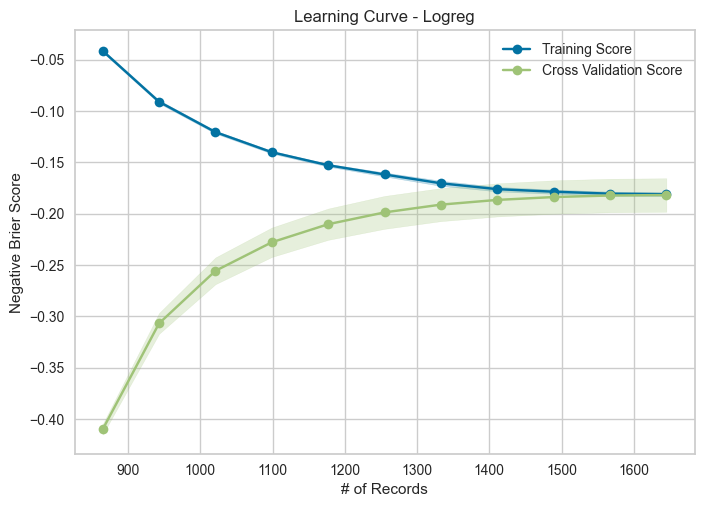

In [26]:
model = LogisticRegression(**best_params)

from yellowbrick.model_selection import ValidationCurve, LearningCurve
plot_learning_curve(train, 'Outcome', features, model, 
                    'neg_brier_score', 
                    "# of Records", 
                    "Negative Brier Score", 
                    "Learning Curve - Logreg", yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23)


### CV Scoring

In [8]:
def rolling_season_cv(model, train_input, features, label='Outcome', cv_start=2007):
    ''' returns estimate for model performance using shifted validation'''
    
    scores = []

    for n, season in enumerate(train_input.Season.unique()):
        
        if season >= cv_start:

            train = train_input[train_input.Season < season]
            test = train_input[train_input.Season == season]

            X_train = train[features]
            X_test = test[features]
            y_train = train[label]
            y_test = test[label]

            model.fit(X_train[features], y_train)
            y_prob = model.predict_proba(X_test[features])
            loss = brier_score_loss(y_test, y_prob[:,1])
            scores.append((season, loss))

    validation_df = pd.DataFrame(scores, columns = ['season', 'score']).sort_values(by = 'score')
    avg_validation_score = validation_df.score.mean()
    return avg_validation_score


In [10]:
model = LogisticRegression(C=.01)
rolling_season_cv(model, train, features)

0.1822338927810267

In [372]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

model = LogisticRegression(C=.01)

X = train[features].values.copy()
y = train[target].values.copy()
preds = y.astype(float).copy()

i = 0
kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
for train_index, val_index in kfold.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # calibrated_model = CalibratedClassifierCV(base_estimator=model, ensemble=False, method='sigmoid')
    # calibrated_model.fit(X_train, y_train)
    model.fit(X_train, y_train)
    preds[val_index] = model.predict_proba(X_val)[:, 1]

print(f"logloss of cvsplit {i}: {log_loss(y,preds)}") 
print(f"brier score of cvsplit {i}: {brier_score_loss(y,preds)}") 


logloss of cvsplit 0: 0.5376748633164768
brier score of cvsplit 0: 0.18220971189745003


In [373]:
train["prob_preds"] = preds

In [109]:
# clf = LogisticRegression(C=.01)
# calibrated_model = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', ensemble=False)
# calibrated_model.fit(X, y)
#calibrated_probs = calibrated_model.predict_proba(X_test)[:, 1]

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.01),
                       ensemble=False)

In [420]:
all_season = []

for s in train.Season.unique():
    X_val = train[train.Season == s].copy()
    X_train = train[train.Season != s].copy()
    X_val = spline_smoothing(X_train, X_val, y_col="Outcome", prob_preds_col="prob_preds", k=5)
    all_season.append(X_val)


In [393]:
# all_season = []

# for i in train.index:
#     X_val = train[train.index == i].copy()
#     X_train = train[train.index != i].copy()
#     X_val = spline_smoothing(X_train, X_val, y_col="Outcome", prob_preds_col="prob_preds", k=5, s=.1)
#     all_season.append(X_val)


In [421]:
new_train = pd.concat(all_season, axis = 0)

In [422]:
brier_score_loss(new_train["Outcome"], new_train.smoothed_prob_preds)

0.1818835243646331

In [385]:
brier_score_loss(new_train["Outcome"], new_train.prob_preds)

0.18220971189745

In [ ]:
# some evidence that smoothing helps, but it's not as good when we CV it vs. when we do it with all data

In [203]:
from scipy.interpolate import UnivariateSpline

train.sort_values(by="prob_preds", inplace = True)
train["smoothed_prob_preds"] = np.clip(UnivariateSpline(train.prob_preds, train.Outcome, k=5)(train.prob_preds),0,1)


In [386]:
def spline_smoothing(train, val, y_col="Outcome", prob_preds_col="prob_preds", s=None, k=3, clip_min=.025, clip_max=.975):
    

    train.sort_values(by=prob_preds_col, inplace = True)
    val["smoothed_prob_preds"] = np.clip(UnivariateSpline(train[prob_preds_col], 
                                                        train[y_col], k=k, s=s)(val[prob_preds_col]),
                                                            clip_min,clip_max,
                                                            )
        
    return val


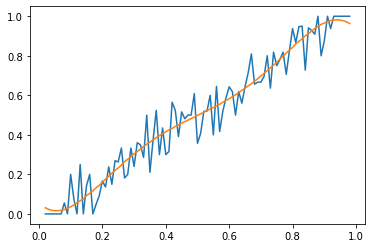

In [204]:
train["prob_preds_rounded"] = train["prob_preds"].apply(lambda x: round(x, 2))
plot_df = train.groupby('prob_preds_rounded')['Outcome'].agg([np.mean, "count"]).reset_index()
plot_df2 = train.groupby('prob_preds_rounded')['smoothed_prob_preds'].agg([np.mean, "count"]).reset_index()

plot_df.columns = ["prob_preds_rounded", "Outcome", "count"]
plot_df2.columns = ["prob_preds_rounded", "smoothed_prob_preds", "count"]

plt.figure()
plt.plot(plot_df.prob_preds_rounded, plot_df.Outcome)
plt.plot(plot_df2.prob_preds_rounded, plot_df2.smoothed_prob_preds)


In [205]:
train["smoothed_prob_preds_rounded"] = train["smoothed_prob_preds"].apply(lambda x: round(x, 1))
train["prob_preds_rounded"] = train["prob_preds"].apply(lambda x: round(x, 1))
tmp_plot = train.groupby('smoothed_prob_preds_rounded')['Outcome', "smoothed_prob_preds"].agg([np.mean, "count"]).reset_index()


/var/folders/2g/465yxy_x4g786jx2llr5xqh40000gn/T/ipykernel_21986/831886628.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp_plot = train.groupby('smoothed_prob_preds_rounded')['Outcome', "smoothed_prob_preds"].agg([np.mean, "count"]).reset_index()


In [206]:
tmp_plot.columns = ["smoothed_prob_preds_rounded", "mean_outcome", "count1", "mean_pred", "count2"]

In [207]:
tmp_plot

,smoothed_prob_preds_rounded,mean_outcome,count1,mean_pred,count2
0,0.0,0.039216,102,0.024921,102
1,0.1,0.078261,115,0.102730,115
2,0.2,0.227586,145,0.204680,145
3,0.3,0.284848,165,0.303071,165
4,0.4,0.406780,236,0.402111,236
5,0.5,0.508091,309,0.499935,309
6,0.6,0.577093,227,0.597481,227
7,0.7,0.707602,171,0.699194,171
8,0.8,0.801418,141,0.798521,141
9,0.9,0.913043,115,0.899599,115


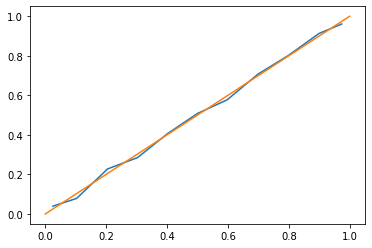

In [208]:
plt.plot(tmp_plot.mean_pred, tmp_plot["mean_outcome"])
plt.plot([x/10 for x in range(11)], [x/10 for x in range(11)])

In [209]:
# still a little biased in the .55 - .65 range, we tend to overestimate perfomance 
# in other words, we predict 59.9% of this cohort will win but 56.4% does

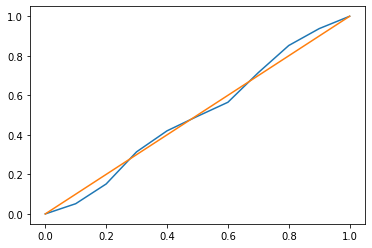

In [210]:
tmp_plot = train.groupby('prob_preds_rounded')['Outcome'].agg([np.mean, "count"]).reset_index()
plt.plot(tmp_plot.prob_preds_rounded, tmp_plot["mean"])
plt.plot([x/10 for x in range(11)], [x/10 for x in range(11)])

In [211]:
train.groupby('prob_preds_rounded')['Outcome'].agg([np.mean, "count"]).reset_index()


,prob_preds_rounded,mean,count
0,0.0,0.000000,23
1,0.1,0.051724,116
2,0.2,0.151515,198
3,0.3,0.314159,226
4,0.4,0.420354,226
5,0.5,0.493878,245
6,0.6,0.564854,239
7,0.7,0.714932,221
8,0.8,0.852041,196
9,0.9,0.937500,112


In [212]:
brier_score_loss(train["Outcome"], train["smoothed_prob_preds"])

0.18074089869904703

In [213]:
0.18220971189745003 - 0.18074089869904703

0.0014688131984030017

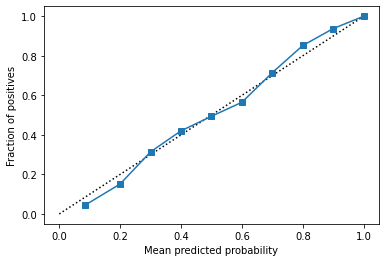

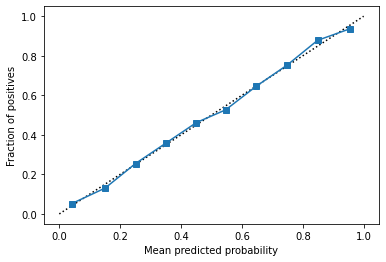

In [214]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

prob_pred_col = 'prob_preds_rounded'

prob_true, prob_pred = calibration_curve(train["Outcome"], train[prob_pred_col], n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, train[prob_pred_col])
disp.plot()

prob_pred_col = 'smoothed_prob_preds'

prob_true, prob_pred = calibration_curve(train["Outcome"], train[prob_pred_col], n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, train[prob_pred_col])
disp.plot()

# CalibrationDisplay(train["Outcome"], train["smoothed_prob_preds"])

# prob_true, prob_pred = calibration_curve(train["Outcome"], train["smoothed_prob_preds"], n_bins=10)
# plt.plot(prob_pred, prob_true)


In [ ]:
# may be some bias here though since we're doing the smoothing using all the labels. 
# maybe need to cv this? Hold one out?
# Also - higher k (for example 5 instead of default of 3 performs better - but might be leading to overfitting)
# Can try running leave one season out and leave one record out cv to see if this method can generalize okay